### Team Lama  Task 3 Submission

### 1) Initialization of the datasets

In the default format the system is trained on the training set and tested on the test set.
Please check the train_folder and test_folder names if you receive errors.

In [1]:
import matplotlib.pyplot as plt

In [2]:
#dev_folder = "train-split/tasks-2-3/train-dev" # if dev folder and propaganda-techniques-names.txt are not in the same folder as this 
dev_folder = "dev"
test_folder = "test-Input/tasks-2-3/test"
propaganda_techniques_file = "propaganda-techniques-names.txt" # notebook, change these variables accordingly

import glob
import os.path
import random
import re

regex = re.compile("article([0-9]+).*") # regular expression for extracting article id from file name
random.seed(10) # to make runs deterministic
train_folder = "train-split/tasks-2-3/train-train"

Loading training data and the list of technique names
If the testing is done on another set rather than the test set the variable "test_folder" should be replaced accordingly.

In [3]:
# loading articles' content from *.txt files in the dev folder
#file_list = glob.glob(os.path.join(test_folder, "*.txt"))
file_list = glob.glob(os.path.join(test_folder, "*.txt"))
articles_content, articles_id = ([], [])
for filename in file_list:
    with open(filename, "r") as f:  
        articles_content.append(f.read())
        articles_id.append(regex.match(os.path.basename(filename)).group(1)) # extract article id from file name

with open(propaganda_techniques_file, "r") as f:
    propaganda_techniques_names = [ line.rstrip() for line in f.readlines() ]

In [4]:
# loading articles' content from *.txt files in the dev folder
train_file_list = glob.glob(os.path.join(train_folder, "*.txt"))
train_articles_content, train_articles_id = ([], [])
for filename in train_file_list:
    with open(filename, "r") as f:  
        train_articles_content.append(f.read())
        train_articles_id.append(regex.match(os.path.basename(filename)).group(1)) # extract article id from file name

### 2) Training phase on the training set

In [5]:
import nltk
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))

Keywords for each label type is extracted from the training set.

In [6]:
def keywordcounter():
    #print(propaganda_techniques_names)
    my_dict={key: {} for   key in propaganda_techniques_names}
    for file in train_file_list:
        doc = open(file[:-4]+".txt").read()
        labels = open(file[:-4]+".task3.labels").readlines()
        for line in labels:
            ls = line.split()
            label = ls[1]
            inds = (int(ls[2]),int(ls[3]))
            frag = doc[inds[0]:inds[1]]
            #print(label +"\t"+ frag)
            fs = frag.split()
            for f in fs:
                if  f not in stops:
                    if f in my_dict[label]:
                        my_dict[label][f]+=1
                    else:
                        my_dict[label][f]=1
        my_dict2={key: {} for   key in propaganda_techniques_names}
        for key in my_dict:
            for key2 in my_dict[key]:
                #print(key2)
                if my_dict[key][key2]>1:
                    my_dict2[key][key2]=my_dict[key][key2]
    return my_dict2

We have calculated the weights of each keyword inversely proportional to their frequencies

In [7]:
keywords = keywordcounter()
def countfreqs(keywords):
    keycounts = {}
    for label in keywords:
        for word in keywords[label]:
            keycounts[word]=0
    for file in train_file_list:
        doc = open(file[:-4]+".txt").read()
        for key in keycounts:
            keycounts[key]+=doc.count(key)
    return keycounts

In [8]:
keycounts = countfreqs(keywords)

In [9]:
import math
keyweights={}
tot = sum(keycounts.values())
for key in keycounts:
    keyweights[key]= math.sqrt(tot/keycounts[key])

#### keyword weighing example

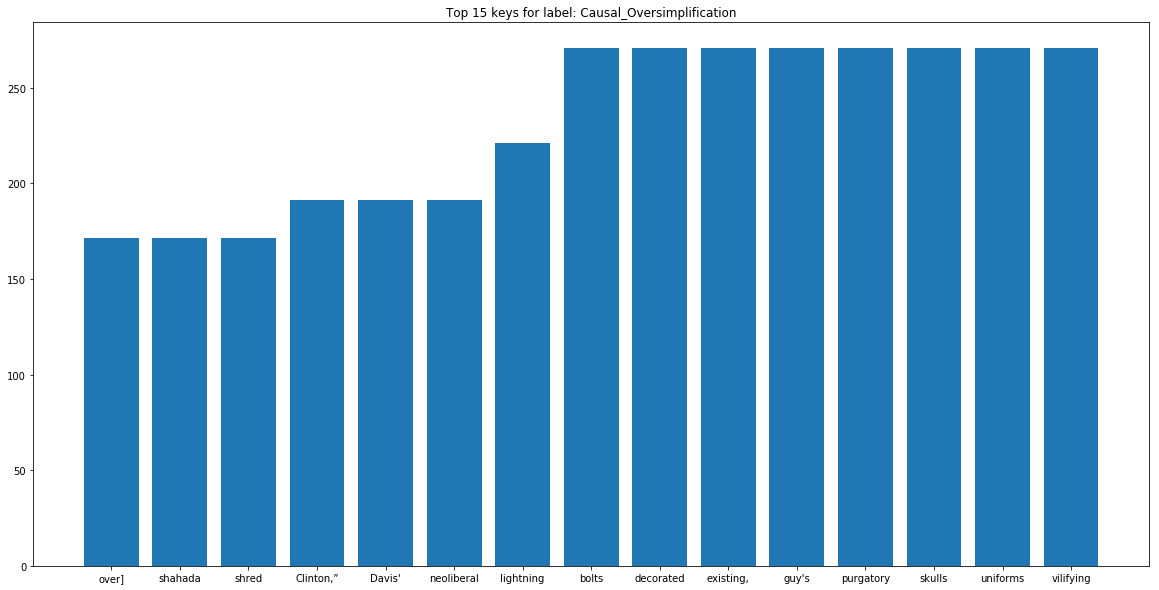

<Figure size 432x288 with 0 Axes>

In [16]:
tech_id = 4
tech_name = propaganda_techniques_names[tech_id]
topx = 15
keylabel = keywords[tech_name]
weightpr = []
for key in keylabel:
    weightpr.append((keyweights[key],key))
weightpr.sort()
topweights = [x[0] for x in weightpr[-topx:]]
topkeys = [x[1] for x in weightpr[-topx:]]
plt.figure(figsize=(20,10))
plt.bar(topkeys,topweights)
plt.title("Top %d keys for label: %s"%(topx,tech_name))
plt.show()
plt.savefig("keywordgraph")

### 3)Prediction Phase
During the prediction phase we have selected the label type which has the maximum score by making use of the keywords extracted on the training phase.

The predictions are written to the document named "example-submission-task3-predictions.txt"

In [294]:
with open("example-submission-task3-predictions.txt", "w") as fout:
    for article_content, article_id in zip(articles_content, articles_id):
        #print(article_id)
        start_fragment, end_fragment, article_length = (0, 0, len(article_content))
        current_article_annotations = []
        #inds = {}
        sents = article_content.split("\n")
        #print(article_id)
        index = 0
        previnds = [(-1,-1)]
        for sent in sents:
            if len(inds)!=0:
                previnds = inds
            maxinds = 0
            maxname = ""
            maxfrag= []
            for tech_name in propaganda_techniques_names:
                my_keys = keywords[tech_name]
                keycount = 0
                inds = []
                for key in my_keys:
                    ind=sent.find(key)
                    #print(key)
                    if ind!=-1:
                        keycount+= my_keys[key]*keyweights[key]
                        #inds.append((ind,ind+len(key)))
                if keycount> maxinds:
                    maxinds=keycount
                    maxfrag = sent
                    maxname = tech_name
            inds = []
            if maxinds>0:
                ind1 = article_content[index:].find(sent)+index
                ind2 = ind1+len(sent)
                #inds = (ind1,ind2)
                if previnds[0]!=ind1:
                    inds= [(ind1,ind2)]
                #print(inds)
            index+= len(sent)
            for ind in inds:
                start_fragment= ind[0]
                end_fragment = ind[1]
                if end_fragment > 0:
                    technique_name = maxname
                    #technique_name = propaganda_techniques_names[random.randint(0, len(propaganda_techniques_names)-1)]
                    # check that there is no other annotation for the same article and technique that overlaps
                    intersection_length = 0
                    if len(current_article_annotations) > 0:
                        span_annotation = set(range(start_fragment, end_fragment))
                        intersection_length = sum( [ len(span_annotation.intersection(previous_fragment))
                                 for previous_technique, previous_fragment in current_article_annotations 
                                 if previous_technique==technique_name ])
                    if len(current_article_annotations) == 0 or intersection_length > -1:
                        #print("start: %s %s"%(start_fragment,end_fragment))
                        fout.write("%s\t%s\t%s\t%s\n" % (article_id, technique_name, start_fragment, end_fragment))
                        current_article_annotations.append((technique_name, set(range(start_fragment, end_fragment))))
                #start_fragment += random.randint(0, max(1, article_length-start_fragment))
                #end_fragment = min(start_fragment + random.randint(1,25), article_length)
            #print("article %s: added %d fragments" % (article_id, len(current_article_annotations)))    